# Model 9b - MLPClassifier with standardization & stratified sampling

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, r2_score, mean_squared_error

from openpyxl import load_workbook

In [2]:
# get data
parentdir = os.path.dirname(os.getcwd())
data = pd.read_excel(parentdir+'\\Data\\SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Ln Safety Factor,Safety Factor Class,Safety Factor Class_1,Safety Factor Class_2,Safety Factor Class_3,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,0.079032,11.0,6.0,1.05,1.05,6349.248707,171.429715,31.846178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,0.185571,13.0,7.0,1.35,1.35,7701.148241,207.931003,31.905513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,-0.109144,9.0,5.0,0.75,0.75,2341.641868,63.224330,36.973415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,-0.384199,7.0,4.0,0.75,0.75,155.345062,4.194317,54.969435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,0.234240,13.0,7.0,1.35,1.35,7468.340623,201.645197,29.688564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 92)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Safety Factor","Safety Factor Class_2","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
print(np.shape(data_model))
data_model.head()

(5000, 10)


,Safety Factor,Safety Factor Class_2,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Friction Angle of Joint 2 (°)
0,1.082239,1.05,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,29.522638
1,1.203906,1.35,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,29.079492
2,0.896601,0.75,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,27.455866
3,0.680996,0.75,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,34.401616
4,1.263948,1.35,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,28.613525


In [5]:
# remove any realizations that are not kinematically possible and any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 10)


In [6]:
data_model['Safety Factor Class_2'] = data_model['Safety Factor Class_2'].apply(str)

## Learning curves for different train_test_split random_states

Variable random_state (=0, 1, 42, 123) for train_test_split. Classification (accuracy and f1-score) and pseudo-regression (r2 and rmse) are performed. For pseudo-regression, the average value of the predicted class is compared with the actual (numeric) safety factor value.

In [8]:
num_samples = []

accuracy_train_subsample_list = []
f1_train_subsample_list = []
accuracy_test_subsample_list = []
f1_test_subsample_list = []

r2_train_subsample_list = []
r2_test_subsample_list = []
rmse_train_subsample_list = []
rmse_test_subsample_list = []

random_state_val = [0,1,42,123]

for x in range(0,4):

    # dataset up to 4950 points
    for i in range(550, 5000, 50):

        print(i)
        
        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)

        # train/test split with different random_state values (0, 1, 42, and 123) and stratified sampling
        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x],stratify=data_subsample['Safety Factor Class_2'])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_train_subsample = train_subsample[["Safety Factor Class_2"]]
        y_train_subsample = np.ravel(y_train_subsample)
        y_train_regr = train_subsample[["Safety Factor"]]
        y_train_regr = np.ravel(y_train_regr)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_test_subsample = test_subsample[["Safety Factor Class_2"]]
        y_test_subsample = np.ravel(y_test_subsample)
        y_test_regr = test_subsample[["Safety Factor"]]
        y_test_regr = np.ravel(y_test_regr)
        y_test_subsample = np.ravel(y_test_subsample)

        # train basic mlp model with default hyperparameters
        # make pipeline for mlp with pre-processing (standardizing the data)
        pipe_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=123))
        pipe_mlp.fit(x_train_subsample, y_train_subsample)

        ypred_mlp = pipe_mlp.predict(x_train_subsample)
        ypred_mlp = np.reshape(ypred_mlp,(len(ypred_mlp),1))
        
        ypred_mlp = np.asarray(np.ravel(ypred_mlp))
        ypred_mlp_float = ypred_mlp.astype(float)

        # training accuracy, f1, r2, and rmse
        accuracy_train_subsample = pipe_mlp.score(x_train_subsample,y_train_subsample)
        f1_train_subsample = f1_score(y_train_subsample,ypred_mlp,average='macro')

        # pseudo-regression (compare with actual value i.e., y_train_regr)
        r2_train_subsample = r2_score(y_train_regr,ypred_mlp_float)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_regr,ypred_mlp_float))
        
        # append training accuracy, f1, r2, and rmse to their respective lists
        accuracy_train_subsample_list.append(accuracy_train_subsample)
        f1_train_subsample_list.append(f1_train_subsample)
       
        r2_train_subsample_list.append(r2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)
    
        # test the mlp model
        # predict y test
        ypred_test_mlp = pipe_mlp.predict(x_test_subsample)
        ypred_test_mlp = np.reshape(ypred_test_mlp,(len(ypred_test_mlp),1))
        
        ypred_test_mlp = np.asarray(np.ravel(ypred_test_mlp))
        ypred_test_mlp_float = ypred_test_mlp.astype(float)

        # test accuracy, f1, r2, and rmse
        accuracy_test_subsample = pipe_mlp.score(x_test_subsample,y_test_subsample)
        f1_test_subsample = f1_score(y_test_subsample,ypred_test_mlp,average='macro')

        # pseudo-regression (compare with actual value i.e., y_test_regr)
        r2_test_subsample = r2_score(y_test_regr,ypred_test_mlp_float)
        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_regr,ypred_test_mlp_float))
        
        # append test accuracy, f1, r2, and rmse to their respective lists
        accuracy_test_subsample_list.append(accuracy_test_subsample)
        f1_test_subsample_list.append(f1_test_subsample)
        
        r2_test_subsample_list.append(r2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
    
    # entire dataset (4955 points)
    num_samples.append(len(data_model.index))

    # get subsample of data
    data_subsample = data_model.sample(n = len(data_model.index),random_state = 1)

    # train/test split with different random_state values (0, 1, 42, and 123) and stratified sampling
    train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x],stratify=data_subsample['Safety Factor Class_2'])
    
    x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_train_subsample = train_subsample[["Safety Factor Class_2"]]
    y_train_subsample = np.ravel(y_train_subsample)
    y_train_regr = train_subsample[["Safety Factor"]]
    y_train_regr = np.ravel(y_train_regr)

    x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_test_subsample = test_subsample[["Safety Factor Class_2"]]
    y_test_subsample = np.ravel(y_test_subsample)
    y_test_regr = test_subsample[["Safety Factor"]]
    y_test_regr = np.ravel(y_test_regr)
    y_test_subsample = np.ravel(y_test_subsample)

    # train basic mlp model with default hyperparameters
    # make pipeline for mlp with pre-processing (standardizing the data)
    pipe_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=123))
    pipe_mlp.fit(x_train_subsample, y_train_subsample)

    ypred_mlp = pipe_mlp.predict(x_train_subsample)
    ypred_mlp = np.reshape(ypred_mlp,(len(ypred_mlp),1))

    ypred_mlp = np.asarray(np.ravel(ypred_mlp))
    ypred_mlp_float = ypred_mlp.astype(float)

    # training accuracy, f1, r2, and rmse
    accuracy_train_subsample = pipe_mlp.score(x_train_subsample,y_train_subsample)
    f1_train_subsample = f1_score(y_train_subsample,ypred_mlp,average='macro')

    # pseudo-regression (compare with actual value i.e., y_train_regr)
    r2_train_subsample = r2_score(y_train_regr,ypred_mlp_float)
    rmse_train_subsample = math.sqrt(mean_squared_error(y_train_regr,ypred_mlp_float))

    # append training accuracy, f1, r2, and rmse to their respective lists
    accuracy_train_subsample_list.append(accuracy_train_subsample)
    f1_train_subsample_list.append(f1_train_subsample)

    r2_train_subsample_list.append(r2_train_subsample)
    rmse_train_subsample_list.append(rmse_train_subsample)

    # test the mlp model
    # predict y test
    ypred_test_mlp = pipe_mlp.predict(x_test_subsample)
    ypred_test_mlp = np.reshape(ypred_test_mlp,(len(ypred_test_mlp),1))

    ypred_test_mlp = np.asarray(np.ravel(ypred_test_mlp))
    ypred_test_mlp_float = ypred_test_mlp.astype(float)

    # test accuracy, f1, r2, and rmse
    accuracy_test_subsample = pipe_mlp.score(x_test_subsample,y_test_subsample)
    f1_test_subsample = f1_score(y_test_subsample,ypred_test_mlp,average='macro')

    # pseudo-regression (compare with actual value i.e., y_test_regr)
    r2_test_subsample = r2_score(y_test_regr,ypred_test_mlp_float)
    rmse_test_subsample = math.sqrt(mean_squared_error(y_test_regr,ypred_test_mlp_float))

    # append test accuracy, f1, r2, and rmse to their respective lists
    accuracy_test_subsample_list.append(accuracy_test_subsample)
    f1_test_subsample_list.append(f1_test_subsample)

    r2_test_subsample_list.append(r2_test_subsample)
    rmse_test_subsample_list.append(rmse_test_subsample)

550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4000


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4050


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4100


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4150


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4200


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4250


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4300


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4350


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4400


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4450


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4500


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4550


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4600


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4650


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4700


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4750


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4800


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4850


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4900


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4950


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# transform lists of results into dataframes
num_samples = pd.DataFrame(num_samples)

accuracy_train_subsample_list = pd.DataFrame(accuracy_train_subsample_list)
f1_train_subsample_list = pd.DataFrame(f1_train_subsample_list)
accuracy_test_subsample_list = pd.DataFrame(accuracy_test_subsample_list)
f1_test_subsample_list = pd.DataFrame(f1_test_subsample_list)

r2_train_subsample_list = pd.DataFrame(r2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
r2_test_subsample_list = pd.DataFrame(r2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)

In [10]:
# concatenate dataframes into one result dataframe
rslts = pd.concat([num_samples,accuracy_train_subsample_list,f1_train_subsample_list,r2_train_subsample_list,rmse_train_subsample_list,accuracy_test_subsample_list,f1_test_subsample_list,r2_test_subsample_list,rmse_test_subsample_list],axis=1)

In [11]:
# divide the rslts dataframe by the random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
print(random_state_len)
print(max(np.shape(rslts)))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

randomstate123_rslts.tail()

90
360


,0,0,0,0,0,0,0,0,0
355,4800,0.956250,0.828283,0.812820,0.219972,0.912500,0.659167,0.754844,0.270598
356,4850,0.959278,0.866038,0.785379,0.247112,0.908247,0.691012,0.894585,0.144990
357,4900,0.958163,0.827648,0.813919,0.220179,0.911224,0.701055,0.765197,0.260249
358,4950,0.959091,0.855997,0.786400,0.242164,0.923232,0.700395,0.888475,0.158403
359,4992,0.960180,0.855529,0.811313,0.224632,0.912913,0.664866,0.775712,0.240894


In [12]:
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])


In [13]:
randomstate123_rslts_pd.tail()

,num_samples,accuracy_train_subsample,f1_train_subsample,r2_train_subsample,rmse_train_subsample,accuracy_test_subsample,f1_test_subsample,r2_test_subsample,rmse_test_subsample
85,4800.0,0.956250,0.828283,0.812820,0.219972,0.912500,0.659167,0.754844,0.270598
86,4850.0,0.959278,0.866038,0.785379,0.247112,0.908247,0.691012,0.894585,0.144990
87,4900.0,0.958163,0.827648,0.813919,0.220179,0.911224,0.701055,0.765197,0.260249
88,4950.0,0.959091,0.855997,0.786400,0.242164,0.923232,0.700395,0.888475,0.158403
89,4992.0,0.960180,0.855529,0.811313,0.224632,0.912913,0.664866,0.775712,0.240894


(0.0, 1.0)

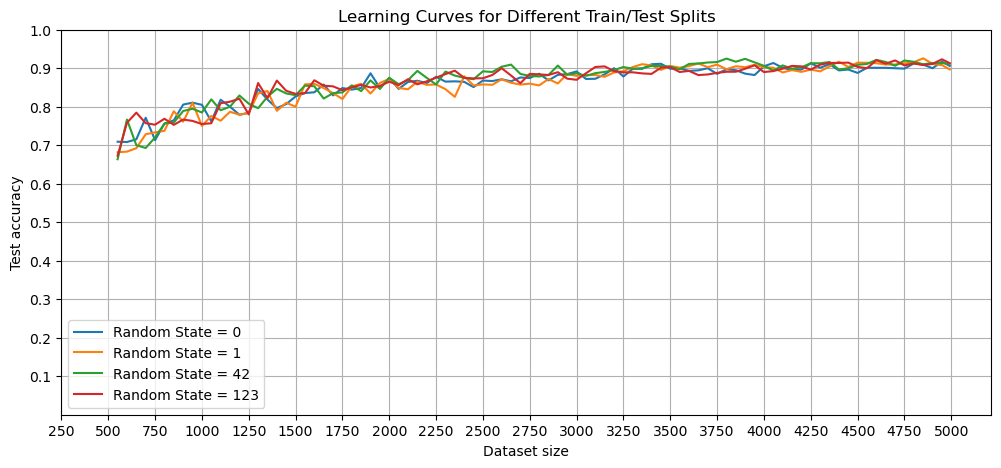

In [14]:
# plot learning curves for different train/test splits for test accuracy
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['accuracy_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['accuracy_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['accuracy_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['accuracy_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test accuracy')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])
plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x2b409f595e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

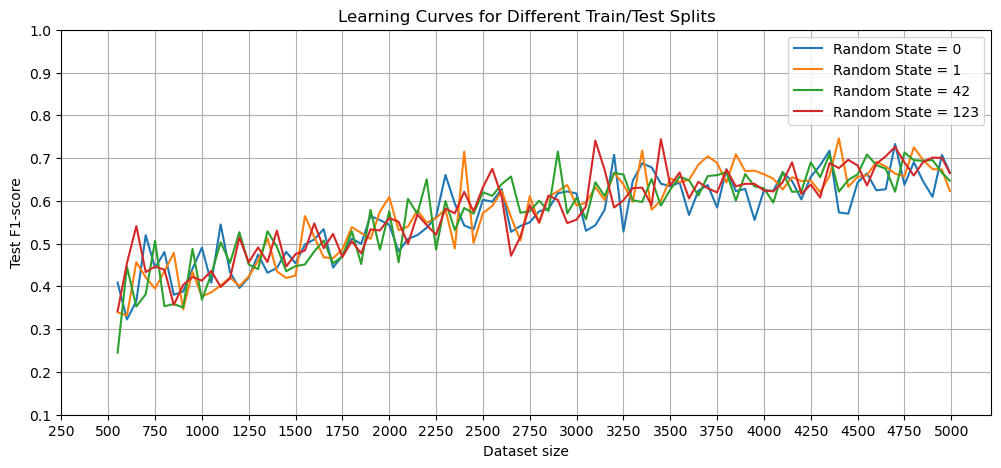

In [15]:
# plot learning curves for different train/test splits for test f1
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['f1_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['f1_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['f1_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['f1_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test F1-score')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x2b40a0aed30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

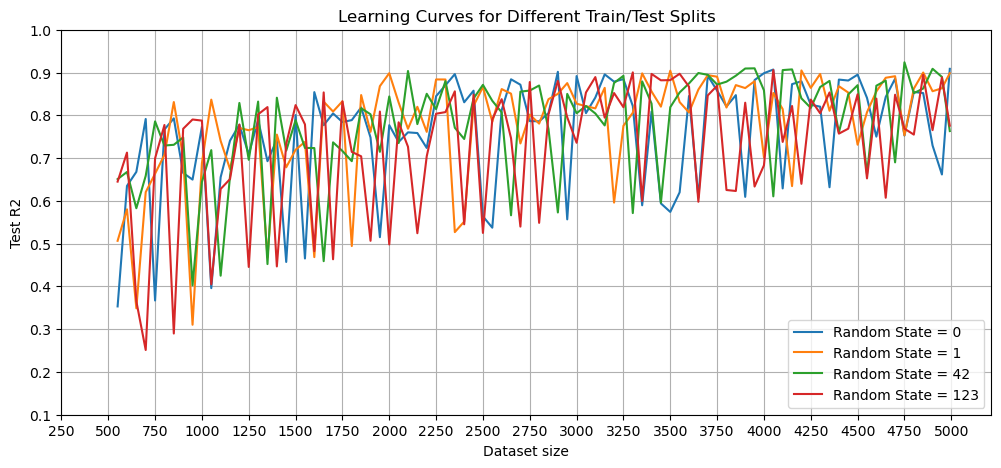

In [16]:
# plot learning curves for different train/test splits for test r2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['r2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['r2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['r2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['r2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x2b40ba437c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

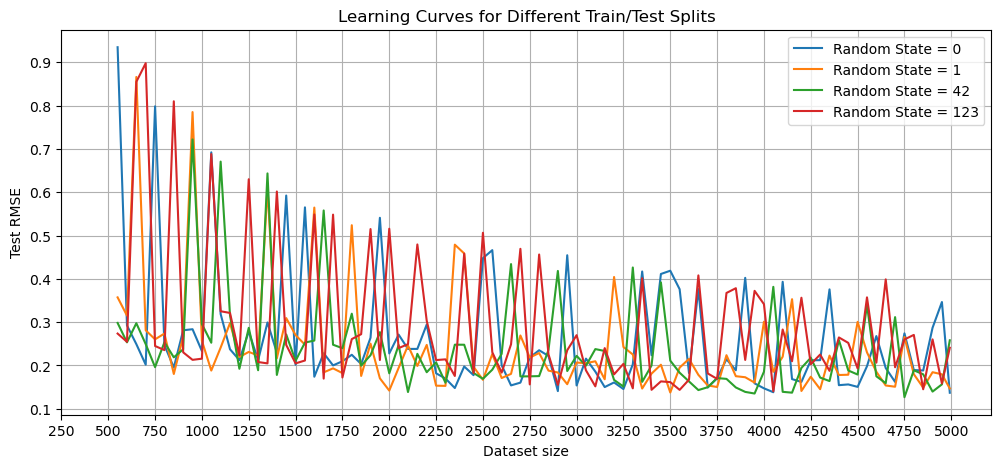

In [17]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x2b409da6850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

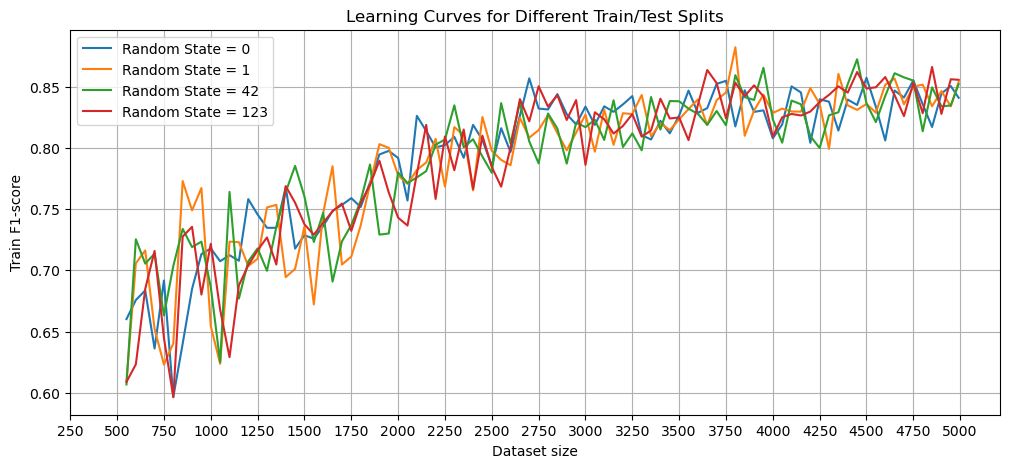

In [18]:
# plot learning curves for different train/test splits for train f1
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['f1_train_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['f1_train_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['f1_train_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['f1_train_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Train F1-score')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [19]:
# train accuracy - test accuracy
randomstate0_accuracydiff = randomstate0_rslts_pd['accuracy_train_subsample'] - randomstate0_rslts_pd['accuracy_test_subsample']
randomstate1_accuracydiff = randomstate1_rslts_pd['accuracy_train_subsample'] - randomstate1_rslts_pd['accuracy_test_subsample']
randomstate42_accuracydiff = randomstate42_rslts_pd['accuracy_train_subsample'] - randomstate42_rslts_pd['accuracy_test_subsample']
randomstate123_accuracydiff = randomstate123_rslts_pd['accuracy_train_subsample'] - randomstate123_rslts_pd['accuracy_test_subsample']

# train f1 - test f1
randomstate0_f1diff = randomstate0_rslts_pd['f1_train_subsample'] - randomstate0_rslts_pd['f1_test_subsample']
randomstate1_f1diff = randomstate1_rslts_pd['f1_train_subsample'] - randomstate1_rslts_pd['f1_test_subsample']
randomstate42_f1diff = randomstate42_rslts_pd['f1_train_subsample'] - randomstate42_rslts_pd['f1_test_subsample']
randomstate123_f1diff = randomstate123_rslts_pd['f1_train_subsample'] - randomstate123_rslts_pd['f1_test_subsample']


# train r2 - test r2
randomstate0_r2diff = randomstate0_rslts_pd['r2_train_subsample'] - randomstate0_rslts_pd['r2_test_subsample']
randomstate1_r2diff = randomstate1_rslts_pd['r2_train_subsample'] - randomstate1_rslts_pd['r2_test_subsample']
randomstate42_r2diff = randomstate42_rslts_pd['r2_train_subsample'] - randomstate42_rslts_pd['r2_test_subsample']
randomstate123_r2diff = randomstate123_rslts_pd['r2_train_subsample'] - randomstate123_rslts_pd['r2_test_subsample']

# test rmse - train rmse
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']


([<matplotlib.axis.XTick at 0x2b409e86040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

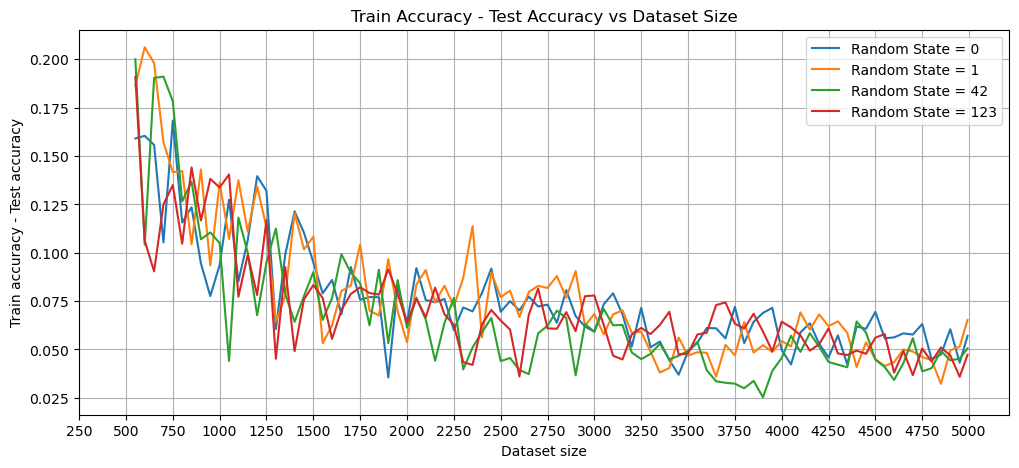

In [20]:
# plot accuracy diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_accuracydiff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_accuracydiff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_accuracydiff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_accuracydiff,label='Random State = 123')
plt.title('Train Accuracy - Test Accuracy vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train accuracy - Test accuracy')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x2b40d42de50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

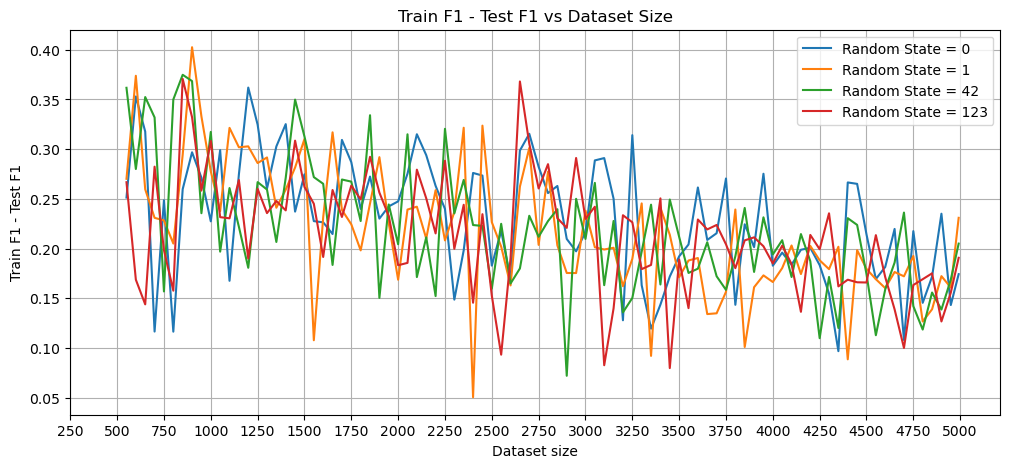

In [21]:
# plot f1 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_f1diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_f1diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_f1diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_f1diff,label='Random State = 123')
plt.title('Train F1 - Test F1 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train F1 - Test F1')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x2b40d240c70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

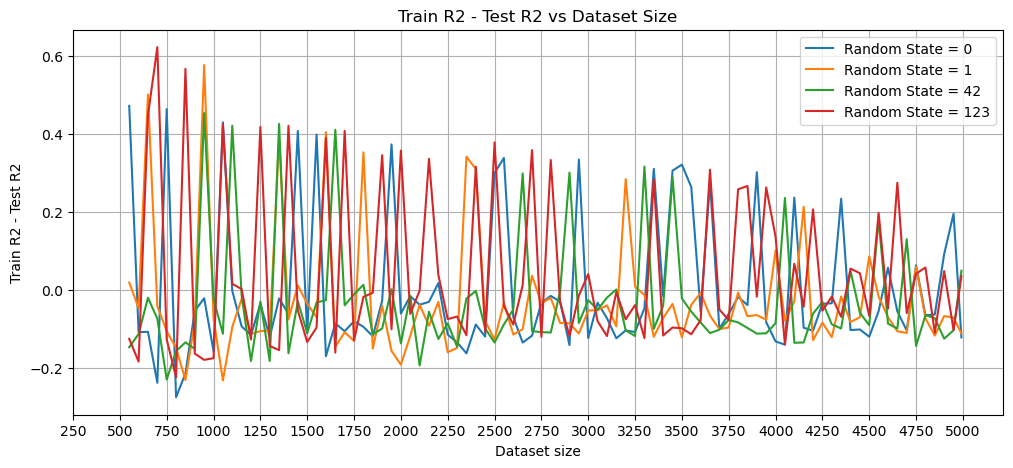

In [22]:
# plot r2 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_r2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_r2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_r2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_r2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x2b40d2e97f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

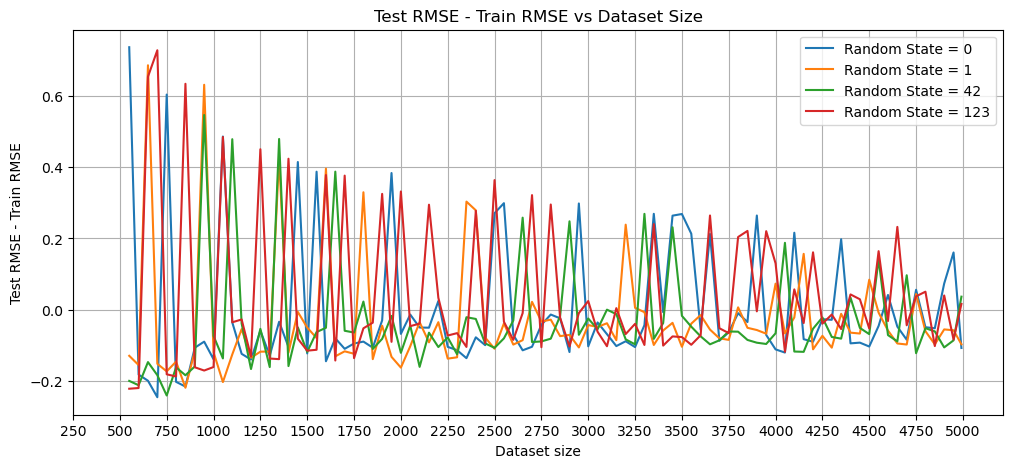

In [23]:
# plot rmse diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [24]:
# concatenate results for each random_state value into one dataframe for output into Excel
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)
rslts_formatted

,num_samples,accuracy_train_subsample,f1_train_subsample,r2_train_subsample,rmse_train_subsample,accuracy_test_subsample,f1_test_subsample,r2_test_subsample,rmse_test_subsample,num_samples,...,rmse_test_subsample,num_samples,accuracy_train_subsample,f1_train_subsample,r2_train_subsample,rmse_train_subsample,accuracy_test_subsample,f1_test_subsample,r2_test_subsample,rmse_test_subsample
0,550.0,0.868182,0.660145,0.825427,0.198019,0.709091,0.408862,0.353178,0.935011,550.0,...,0.298230,550.0,0.863636,0.608869,0.519904,0.495471,0.672727,0.342137,0.644912,0.273667
1,600.0,0.868750,0.675705,0.527293,0.474488,0.708333,0.322634,0.634921,0.292429,600.0,...,0.253406,600.0,0.864583,0.623240,0.529453,0.474479,0.758333,0.454596,0.712729,0.254641
2,650.0,0.871154,0.683613,0.560831,0.448720,0.715385,0.365906,0.667725,0.249255,650.0,...,0.297581,650.0,0.875000,0.684713,0.813772,0.200868,0.784615,0.540913,0.365297,0.855135
3,700.0,0.876786,0.636133,0.553793,0.447556,0.771429,0.519703,0.791307,0.201881,700.0,...,0.249284,700.0,0.882143,0.715843,0.873873,0.169611,0.757143,0.433453,0.251325,0.898128
4,750.0,0.881667,0.691622,0.830902,0.194446,0.713333,0.443028,0.367038,0.798520,750.0,...,0.196089,750.0,0.888333,0.644690,0.572978,0.426271,0.753333,0.446349,0.699245,0.244956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,4800.0,0.957552,0.835604,0.790275,0.238604,0.912500,0.690265,0.854611,0.189456,4800.0,...,0.188923,4800.0,0.956250,0.828283,0.812820,0.219972,0.912500,0.659167,0.754844,0.270598
86,4850.0,0.956701,0.817004,0.789365,0.240469,0.909278,0.645328,0.851876,0.188367,4850.0,...,0.179557,4850.0,0.959278,0.866038,0.785379,0.247112,0.908247,0.691012,0.894585,0.144990
87,4900.0,0.960459,0.844338,0.821974,0.213681,0.900000,0.609308,0.729412,0.287102,4900.0,...,0.139644,4900.0,0.958163,0.827648,0.813919,0.220179,0.911224,0.701055,0.765197,0.260249
88,4950.0,0.960354,0.850394,0.857370,0.185809,0.917172,0.707292,0.661603,0.346547,4950.0,...,0.156370,4950.0,0.959091,0.855997,0.786400,0.242164,0.923232,0.700395,0.888475,0.158403


In [25]:
# output results to Excel
book = load_workbook(parentdir+'\\ML Models Results\\Model9b_Results.xlsx')
writer = pd.ExcelWriter(parentdir+'\\ML Models Results\\Model9b_Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'FORMATTED')
writer.save()
writer.close()